Test MSE: 0.0415
Saved artifact at '/tmp/tmpwcra3fgz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135485982839376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135485982842640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135485982844368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135485982840144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135485982844560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135485982842256: TensorSpec(shape=(), dtype=tf.resource, name=None)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


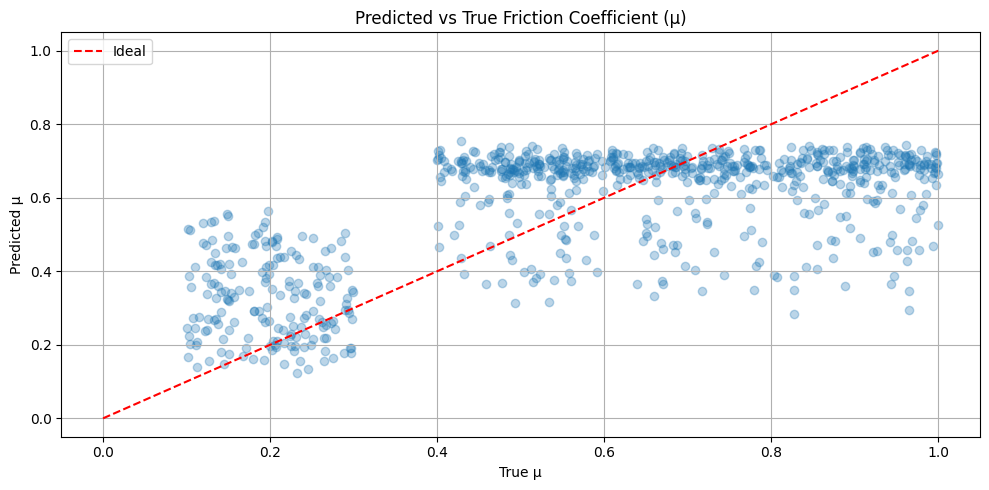

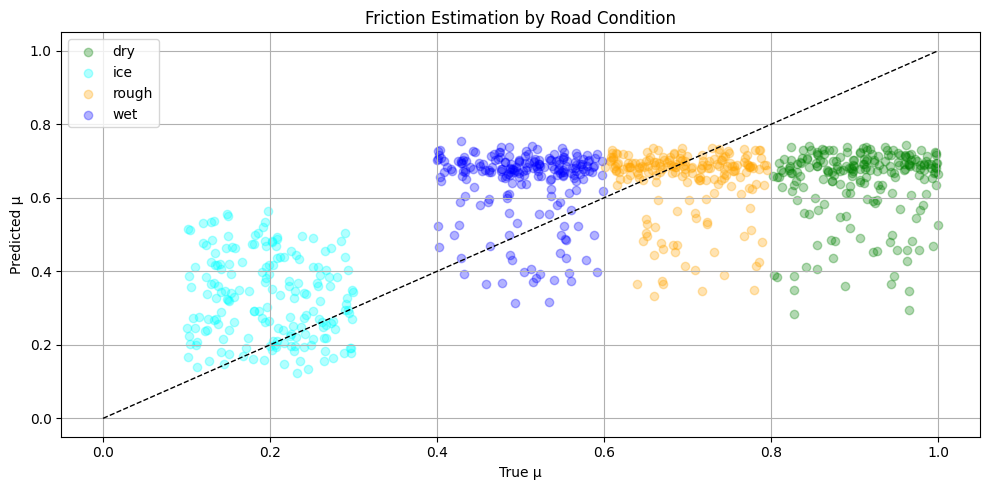

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib

# Step 1: Simulated physics-informed data generation
def simulate_training_data(n=4000):
    road_types = {
        'dry': (0.8, 1.0),
        'wet': (0.4, 0.6),
        'rough': (0.6, 0.8),
        'ice': (0.1, 0.3)
    }
    X, y, labels = [], [], []
    for label, (mu_min, mu_max) in road_types.items():
        for _ in range(n // 4):
            v = np.random.uniform(10, 30)  # speed [m/s]
            slip = np.random.uniform(0.01, 0.3)  # slip ratio
            brake = np.random.uniform(1, 6)  # brake pressure [bar]
            ax = np.random.uniform(0.1, 0.8) if label != 'ice' else np.random.uniform(0.01, 0.2)
            ay = slip * ax * 1.5  # simplified lateral accel
            mu = np.random.uniform(mu_min, mu_max)
            X.append([ax, ay, slip, brake, v])
            y.append(mu)
            labels.append(label)
    return np.array(X), np.array(y), np.array(labels)

# Step 2: Data generation and scaling
X, y, labels = simulate_training_data()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train-test split
# Splitting the data and labels into training and testing sets.
X_train, X_test, y_train, y_test, labels_train, label_test = train_test_split(
    X_scaled, y, labels, test_size=0.2, random_state=42
)
# The function returns 6 values: X_train, X_test, y_train, y_test, labels_train, and labels_test.
# These values are assigned to the respective variables for further use in model training and evaluation.

# Step 4: Model definition and training
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(5,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=0, validation_split=0.1)

# Step 5: Evaluation and export
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {loss:.4f}")

# Export model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("mu_estimator.tflite", "wb") as f:
    f.write(tflite_model)

# Export scaler
joblib.dump(scaler, "mu_scaler.save")

# Step 6: Prediction and graphing
y_pred = model.predict(X_test).flatten()

# Plot 1: Predicted vs True μ
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.xlabel("True μ")
plt.ylabel("Predicted μ")
plt.title("Predicted vs True Friction Coefficient (μ)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Distribution by condition
colors = {'dry': 'green', 'wet': 'blue', 'rough': 'orange', 'ice': 'cyan'}
plt.figure(figsize=(10, 5))
for condition in np.unique(label_test):
    idx = label_test == condition
    plt.scatter(y_test[idx], y_pred[idx], alpha=0.3, label=condition, color=colors[condition])
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("True μ")
plt.ylabel("Predicted μ")
plt.title("Friction Estimation by Road Condition")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
